In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

df = pd.read_csv("data/allendale-students.csv")

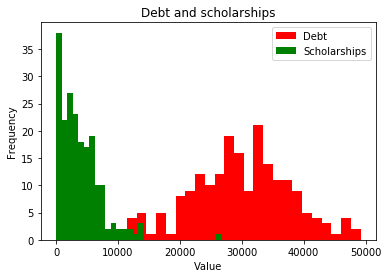

In [2]:
n_bins = 30
colors = ["red", "green"]
plt.hist(df.debt, bins=n_bins, color=colors[0])
plt.hist(df.scholarship, bins=n_bins, color=colors[1])
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title("Debt and scholarships")
labels= ["Debt","Scholarships"]
_ = plt.legend(labels)

In [3]:
df_with_dummies = pd.get_dummies(df).drop(columns=['housing_off campus', 'major_STEM']) 
df_with_dummies.columns = df_with_dummies.columns.str.replace(' ', '_')
df_with_dummies # off-campus and stem majors are reference catgories

,distance,scholarship,parents,car,debt,housing_on_campus,major_business,major_other
0,40,1532,0.440,6,26389,0,0,0
1,30,7479,0.265,7,21268,1,0,0
2,130,2664,0.115,3,32312,1,1,0
3,120,1998,0.325,9,28539,1,1,0
4,30,1462,0.105,10,34867,0,0,1
...,...,...,...,...,...,...,...,...
195,30,5321,0.445,8,21873,0,0,0
196,50,5916,0.020,10,33122,0,0,0
197,410,5583,0.200,7,33666,1,1,0
198,320,1282,0.250,4,44262,0,1,0


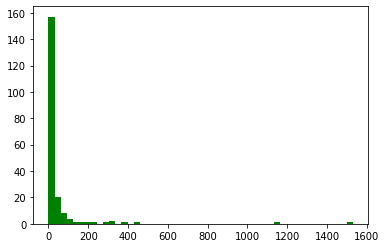

In [4]:
df['scholarship_debt'] = df['debt']/ df['scholarship']
n_bins = 50
_ = plt.hist(df['scholarship_debt'], bins=n_bins, color=colors[1])

In [ ]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so[so!=1]

In [5]:
predictors = df_with_dummies.drop(columns='debt')
cols = predictors.columns

## Get formula

In [6]:
formula_list = []
n_columns = len(cols) + 1
for i in range(1, n_columns):
    iters = combinations(cols, i)
    for item in iters:
        formula = "debt ~ " + " + ".join(item)
        formula_list.append(formula)

In [57]:
def count_params(model):
    params = model.replace("+", ",")
    params = params.replace("debt ~", "")
    n_params = params.count(',') + 1
    return n_params

def get_r_sq(model):
    mod = smf.ols(formula=model, data=df_with_dummies)
    res = mod.fit()
    return res.rsquared_adj

def get_coefs(model):
    mod = smf.ols(formula=model, data=df_with_dummies)
    res = mod.fit()
    return res.params

In [60]:
adj_r_df = pd.DataFrame({'model': formula_list, 
                         'adj_rsq': map(get_r_sq, formula_list),
                         'n_params': map(count_params, formula_list),
                         'coefs': map(get_coefs, formula_list) # we really dont want to run this twice :()
                         })

In [66]:
# df_c = pd.concat([df_a.reset_index(drop=True), df_b], axis=1)
coefs = pd.DataFrame(adj_r_df.coefs.tolist())
model_results = pd.concat([adj_r_df.reset_index(drop=True), coefs], axis=1)
model_results = model_results.drop(columns=['coefs'])

,model,adj_rsq,n_params,Intercept,distance,scholarship,parents,car,housing_on_campus,major_business,major_other
0,debt ~ distance,0.244302,1,24910.734233,47.250034,NaN,NaN,NaN,NaN,NaN,NaN
1,debt ~ scholarship,0.410439,1,35735.773269,NaN,-1.606293,NaN,NaN,NaN,NaN,NaN
2,debt ~ parents,0.136616,1,35587.432644,NaN,NaN,-22931.586888,NaN,NaN,NaN,NaN
3,debt ~ car,-0.005043,1,29553.705664,NaN,NaN,NaN,-11.437947,NaN,NaN,NaN
4,debt ~ housing_on_campus,0.004770,1,28789.608333,NaN,NaN,NaN,NaN,1707.791667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
122,debt ~ distance + scholarship + parents + hous...,0.745326,6,37340.465783,40.096679,-1.535280,-22732.180567,NaN,535.129515,849.541682,-984.887606
123,debt ~ distance + scholarship + car + housing_...,0.605251,6,30807.718552,42.366533,-1.517433,NaN,43.162770,553.237747,209.122068,-570.624572
124,debt ~ distance + parents + car + housing_on_c...,0.368468,6,30864.417863,44.348504,NaN,-22050.624647,-136.820594,720.892165,2603.353304,297.322404
125,debt ~ scholarship + parents + car + housing_o...,0.565958,6,41505.104362,NaN,-1.612190,-24388.569853,-4.936134,1442.239395,1085.012177,-734.881610


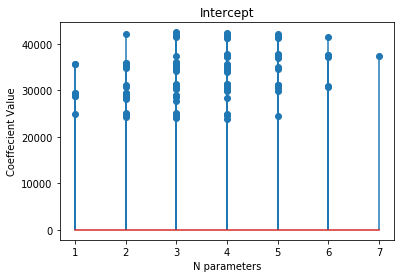

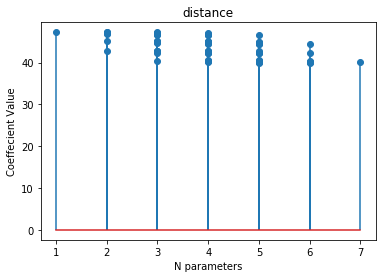

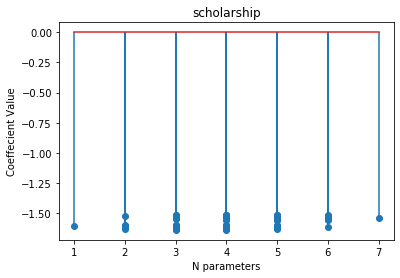

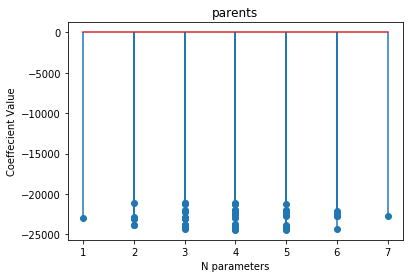

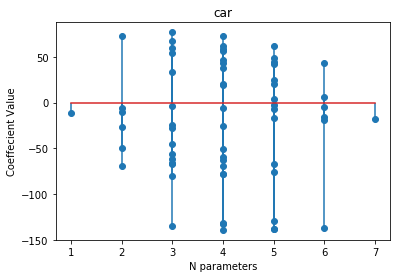

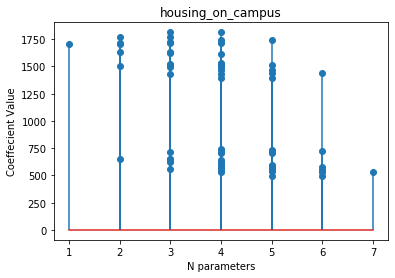

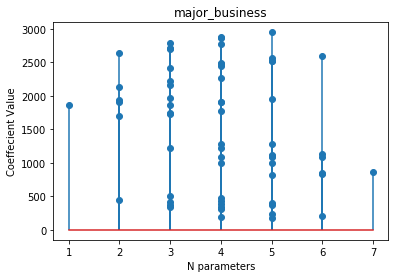

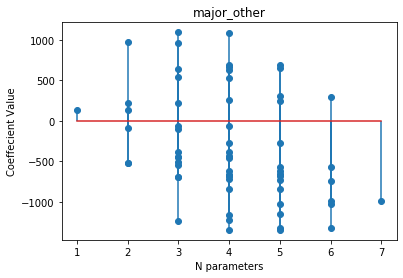

In [85]:
terms = model_results.columns[4:]
for term in terms:
    plt.stem(model_results.n_params, model_results[term], use_line_collection=True)
    plt.ylabel('Coeffecient Value')
    plt.xlabel('N parameters')
    plt.title(term)
    plt.show()

In [121]:
# def summary_stats(model):
    
reg_output_min = model_results.iloc[:,4:].min()
reg_output_max = model_results.iloc[:,4:].max()

# TODO: get df of min/max coefs

,0,1
0,23951.845152,NaN
1,39.993163,NaN
2,-1.637079,NaN
3,-24444.948252,NaN
4,-139.217687,NaN
5,493.153200,NaN
6,175.608545,NaN
7,-1344.525465,NaN
Intercept,NaN,42521.429776
car,NaN,76.826684


In [114]:
col_sums = eg_output.sum()
col_sums.round(5)

AttributeError: 'function' object has no attribute 'round'